In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

%run functions_for_ESR_data_processing.ipynb

In [2]:
# folder which contains all of the X-band data files
folder = "C:\\Users\\F25_1.307_b\\Box Sync\\Klingeler_Masterarbeit\\howardevansite\\LiCuFe2(VO4)3 powder\\X-band\\21_02_2019"

# list of the names of all the files in "folder" 
# files with different endings (.DTA, .dat, DSC, ...) all only appear once
files = [i[:-4] for i in os.listdir(folder) if i[-3:] == 'dat']

# extracts the temperature from the filename
# argument is just name of the file
def temperature (name):
    start = name.find('_')
    end = name.find('K')
    
    temp = name[start+1:end]
    if temp.find('p') == -1:
        temp_new = temp
    else:
        middle = temp.find('p')
        temp_new = temp[:middle] + '.' + temp[middle+1:]
    temp_new = str("%.1f" % float(temp_new))
    return temp_new+' K'
    

# extracts the freqeuncy from the .DSC file
# argument needs to be filename of .DSC file (icluding full path and .DSC ending)
def frequency (filename):
    f = open (filename, 'r')
    for line in f:
        if line[0:9] == 'Frequency':
            line = line.strip()
            line = line.split()
            frequency = line[1] + ' ' + line[2]
    return frequency


# none of the following important for any of the following procedure but makes it easier accessing individual files

# this routine sorts the filenames in "files" according to their temperatures
# and gives an array "temperatures" with the ordered temperatures
temperatures = []
for name in files:
    temp_new = temperature(name)[:-2]    
    temperatures.append(float(temp_new))

temperatures = np.array(temperatures)
files = np.array(files)

files = files[temperatures.argsort()]
temperatures = sorted(temperatures)

# this prints the temperatures and and index which tells you the position
# of the name of the file at this temperature in the array "files"
# e.g. if one element of this array is [5, 9.4] then files[5]='..._9p4K'

print ([[i, np.round(temperatures[i], decimals=1)] for i in np.arange(len(temperatures))])


[[0, 4.3], [1, 4.5], [2, 5.1], [3, 5.2], [4, 5.9], [5, 6.6], [6, 6.6], [7, 7.0], [8, 8.0], [9, 9.3], [10, 10.1], [11, 11.0], [12, 12.0], [13, 13.3], [14, 13.3], [15, 14.7], [16, 16.2], [17, 18.0], [18, 19.9], [19, 22.3], [20, 24.7], [21, 27.4], [22, 30.2], [23, 32.9], [24, 35.5], [25, 38.0], [26, 40.8], [27, 43.6], [28, 46.2], [29, 49.3], [30, 52.6], [31, 56.9], [32, 60.6], [33, 64.4], [34, 68.6], [35, 68.6], [36, 73.7], [37, 80.0], [38, 80.0], [39, 86.7], [40, 95.6], [41, 104.7], [42, 115.2], [43, 125.2], [44, 150.1], [45, 168.1], [46, 182.2], [47, 190.1], [48, 196.5], [49, 213.0], [50, 241.5], [51, 250.4], [52, 259.0], [53, 269.6]]


Changes all the .dat files in the given folder in the following way
- deletes the index column
- puts field to the left (X-data)
- puts signal in the other column (Y-data)
- writes frequency in comment line of field column
- writes temperature in comment line of signal column
- saves file in the same folder with the name "..._processed.txt"

In [ ]:
files = [i for i in files if i!='NaCuFe2_180p5K']

for data_file in files:
    _, bfield, signal = data_import ( folder+'\\'+data_file+'.dat', 2)
    
    data = [bfield, signal]
    names = ['B', 'dI/dB']
    units = ['G', 'a.u.']
    comments = [frequency(folder+'\\'+data_file+'.DSC'), temperature(data_file)]
    
#    save(data, names, units, comments, folder+'\\'+data_file+'_processed.txt' )


    
bfield, signal = data_import (folder+'\\NaCuFe2_180p5K.dat', 0)
    
data = [bfield, signal]
names = ['B', 'dI/dB']
units = ['G', 'a.u.']
comments = [frequency(folder+'\\NaCuFe2_180p5K.DSC'), temperature('NaCuFe2_180p5K')]
#save(data, names, units, comments, folder+'\\NaCuFe2_180p5K_processed.txt' )


# Extract all the parameters from the files containing the OriginLab fit results

In [ ]:
# in the Li case
# change of attenuation at T[13]-T[14] and T[34]-T[35]
def rescale_A_Li (A):
    A_new1 = A[:14,0]
    A_new2 = A[14:35, 0]
    A_new3 = A[35:,0]
    
    a1 = A_new1[-1]
    a2 = A_new2[0]
    a3 = A_new2[-1]
    a4 = A_new3[0]
    
    A_new1[-1] = a2
    A_new2[0] = a1
    A_new2[-1] = a4
    A_new3[0] = a3
    
    A_new2 = A_new2 * A_new1[-1]/A_new2[0]
    A_new3 = A_new3 * A_new2[-1]/A_new3[0]
    
    A_new = np.zeros(len(A))
    A_new[:14] = A_new1
    A_new[14:35] = A_new2
    A_new[35:] = A_new3
    
    return A_new


# in the Na case
# change of attenuation at T[12]-T[13]
def rescale_A_Na (A):
    A_new = np.zeros(len(A))
    
    A_new[:13] = A[:13,0]
    A_new[13:] = A[13:,0] * A[12,0]/A[13,0]   
    
    #Aerr_new = np.zeros(len(A))
    #Aerr_new[:13] = A[:13,1]
    #Aerr_new[13:] = A[13:,1] * A[12,0]/A[13,0]
    
    return A_new

# switch to elements i, j of a list
def switch (array, i, j):
    a = array[i]
    b = array[j]
    array[i] = b
    array[j] = a
    return array

In [ ]:
fit_files = np.array([i for i in os.listdir(folder+'\\fit results')])

file_temp = [i[:-4] for i in fit_files]
for i in np.arange(len(file_temp)):
    if file_temp[i].find('_') == -1:
        file_temp[i] = float(file_temp[i])
    else:
        file_temp[i] = file_temp[i][:-4]
        file_temp[i] = float(file_temp[i])

fit_files = np.array(fit_files)[np.array(file_temp).argsort()]
file_temp = sorted(np.array(file_temp))

Temp = []
frequen = []

B01 = []
A1 = []
gamma1 = []

B02 = []
A2 = []
gamma2 = []

B03 = []
A3 = []
gamma3 = []

l = []
m = []
n = []


for data_file in files:
    frequen.append(float(frequency(folder+'\\'+data_file+'.DSC')[:-4]))
    

for data_file in np.arange(len(fit_files)):
    
    Temp.append(file_temp[data_file])
    
    f = open (folder+'\\fit results\\'+fit_files[data_file], 'r')
    f.readline()
    i=0
    fit_parameters = {}
    for line in f:
        line = line.strip()
        line = line.split()
        fit_parameters[line[1]] = [float(line[2]), float(line[3])]
        i=i+1
    
    l.append(fit_parameters['l'])
    m.append(fit_parameters['m'])
    n.append(fit_parameters['n'])
    
    B01.append(fit_parameters['B01'])
    A1.append(fit_parameters['A1'])
    gamma1.append(fit_parameters['g1'])
    
    B02.append(fit_parameters['B02'])
    A2.append(fit_parameters['A2'])
    gamma2.append(fit_parameters['g2'])
    
    if i == 9:
        B03.append([np.nan, np.nan])
        A3.append([np.nan, np.nan])
        gamma3.append([np.nan, np.nan])
    
    elif i == 12:
        B03.append(fit_parameters['B03'])
        A3.append(fit_parameters['A3'])
        gamma3.append(fit_parameters['g3'])

Temp = np.array(Temp)
frequen = np.array(frequen)

B01 = np.array(B01)
A1 = np.array(A1)
gamma1 = np.array(gamma1)

B02 = np.array(B02)
A2 = np.array(A2)
gamma2 = np.array(gamma2)

B03 = np.array(B03)
A3 = np.array(A3)
gamma3 = np.array(gamma3)

l = np.array(l)
m = np.array(m)
n = np.array(n)


A1_new = rescale_A_Li(A1)
A2_new = rescale_A_Li(A2)
#A3_new = rescale_A_Li(A3)

# for Li
B01 = switch(B01, 13, 14)
gamma1 = switch(gamma1, 13, 14)
B02 = switch(B02, 13, 14)
gamma2 = switch(gamma2, 13, 14)
l = switch(l, 13, 14)
m = switch(m, 13, 14)
n = switch(n, 13, 14)

# Fit a single Lorentzian to all data files

In [3]:
def DLorentzian (x, x0, A, gamma):
    return -2 * A * gamma * (x-x0) / ( (x-x0)**2 + gamma**2 )**2

def DLorentzian_w_quadr_background (x, x0, A, gamma, c, d, e):
    return DLorentzian(x, x0, A, gamma) + c*x**2 + d*x + e

def g_factor (frequency,B_resonance):
    g = frequency*10000/B_resonance[:,0]/13.98
    g_err = B_resonance[:,1]*frequency*10000/B_resonance[:,0]/B_resonance[:,0]/13.98
    return g, g_err

In [4]:
#files = [i for i in files if i!='NaCuFe2_180p5K']


freq = []
T = []

B0 = []
A = []
gamma = []

l_single = []
m_single = []
n_single = []

for filename in files:
    freq.append(float(frequency(folder+'\\'+filename+'.DSC')[:-4]))
    T.append(float(temperature(filename)[:-2]))
    
    field, amp = data_import(folder+'\\'+filename+'_processed.txt', 3)
    
    #amp = amp[field<10000]
    #field = field[field<10000]
        
    initial_guess = [3417, 9260089, 770, 5.3e-10, 2.5e-5, -0.43]
    popt, pcov = curve_fit (DLorentzian_w_quadr_background, field, amp,
                            initial_guess, maxfev=20000, ftol=2.220446049250313e-16 )
    
    B0.append([popt[0], pcov[0,0]])
    A.append([popt[1], pcov[1,1]])
    gamma.append([popt[2], pcov[2,2]])
    
    l_single.append([popt[3], pcov[3,3]])
    m_single.append([popt[4], pcov[4,4]])
    n_single.append([popt[5], pcov[5,5]])
    
T = np.array(T)
freq = np.array(freq)

B0 = np.array(B0)
A = np.array(A)
gamma = np.array(gamma)
   
l_single = np.array(l_single)
m_single = np.array(m_single)
n_single = np.array(n_single)

A_new = rescale_A_Li (A)

# Plots

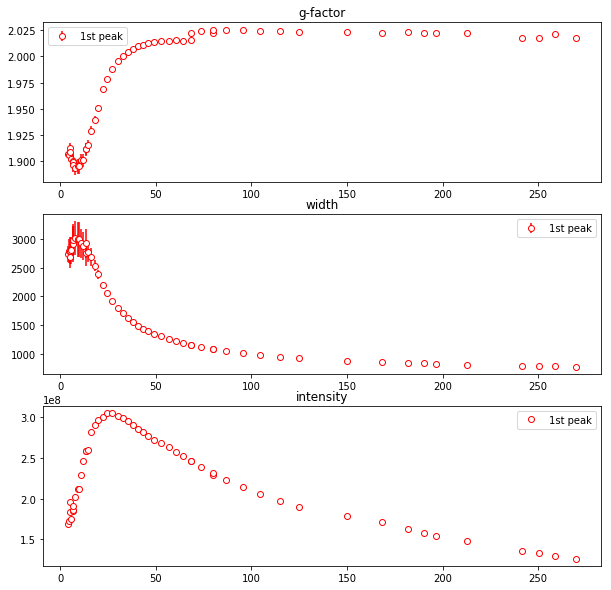

In [5]:
limit = 700

fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10,10))

#g1, g_err1 = g_factor (frequen, B01)
#g2, g_err2 = g_factor (frequen, B02)
#g3, g_err3 = g_factor (frequen, B03)
g4, g_err4 = g_factor (freq, B0)

axes[0].set_title('g-factor')
#axes[0].errorbar(Temp[Temp<limit], g1[Temp<limit], yerr = g_err1[Temp<limit], ecolor='b', fmt='o', mfc = 'b', mec = 'b')
#axes[0].errorbar(Temp[Temp<limit], g2[Temp<limit], yerr = g_err2[Temp<limit], ecolor='orange', fmt='o', mfc = 'orange', mec = 'orange')
#axes[0].errorbar(Temp[Temp<limit], g3[Temp<limit], yerr = g_err3[Temp<limit], ecolor='gray', fmt='o', mfc = 'gray', mec = 'gray')
axes[0].errorbar(T[T<limit], g4[T<limit], yerr = g_err4[T<limit], ecolor='r', fmt='o', mfc = 'white', mec = 'r')
axes[0].legend(['1st peak', '2nd peak', '3rd peak', 'single Lorentzian'])

            

#data1 = gamma1
#data2 = gamma2
#data3 = gamma3
data4 = gamma

axes[1].set_title('width')
#axes[1].errorbar(Temp[Temp<limit], data1[Temp<limit,0], yerr = data1[Temp<limit,1], ecolor='b', fmt='o', mfc = 'b', mec = 'b')
#axes[1].errorbar(Temp[Temp<limit], data2[Temp<limit,0], yerr = data2[Temp<limit,1], ecolor='orange', fmt='o', mfc = 'orange', mec = 'orange')
#axes[1].errorbar(Temp[Temp<limit], data3[Temp<limit,0], yerr = data3[Temp<limit,1], ecolor='gray', fmt='o', mfc = 'gray', mec = 'gray')
axes[1].errorbar(T[T<limit], data4[T<limit,0], yerr = data4[T<limit,1], ecolor='r', fmt='o', mfc = 'white', mec = 'r')
axes[1].legend(['1st peak', '2nd peak', '3rd peak', 'single Lorentzian'])

#data1 = A1_new
#data2 = A2_new
#data3 = A3_new
data4 = A_new

axes[2].set_title('intensity')
#axes[2].errorbar(Temp[Temp<limit], data1[Temp<limit], ecolor='b', fmt='o', mfc = 'b', mec = 'b')
#axes[2].errorbar(Temp[Temp<limit], data2[Temp<limit], ecolor='orange', fmt='o', mfc = 'orange', mec = 'orange')
#axes[2].errorbar(Temp[Temp<limit], data3[Temp<limit], ecolor='gray', fmt='o', mfc = 'gray', mec = 'gray')
axes[2].errorbar(T[T<limit], data4[T<limit], ecolor='r', fmt='o', mfc = 'white', mec = 'r')
axes[2].legend(['1st peak', '2nd peak', '3rd peak', 'single Lorentzian'])

#plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
index = 52

field, amp = data_import(folder+'\\'+files[index]+'_processed.txt', 3)

d1 = one_Lor(field, B0[index,0], A[index,0], gamma[index,0])
#d2 = one_Lor(field, B02[index,0], A2[index,0], gamma2[index,0])
#d3 = one_Lor(field, B03[index,0], A3[index,0], gamma3[index,0])
d2 = 0
d3 = 0
dsum = d1 + d2 + d3
raw_data = amp-(l_single[index,0]*field*field+m_single[index,0]*field+n_single[index,0])

plt.scatter(field, raw_data, s=1, c = 'gray')

#plt.plot(field, d1)
#plt.plot(field, d2)
#plt.plot(field, d3)
plt.plot(field, dsum)
#plt.plot(field, l[index,0]*field**2+m[index,0]*field+n[index,0])

plt.title('T = '+str(Temp[index])+' K')

print ('T = '+str(Temp[index])+' K\nfile = '+files[index])

data = [field/10000, raw_data, dsum, d1, d2]        
names = ['field', 'raw data', 'sum of individual fits', 'fit 1', 'fit 2']
units = ['T', '', '', '', '']
comments = [str(Temp[index])+' K', str(Temp[index])+' K', str(Temp[index])+' K', str(Temp[index])+' K', str(Temp[index])+' K']

#save(data, names, units, comments, folder+'\\individual_fit_curves\\individual_fit_curves_'+str(Temp[index])+'_K.txt' )

In [ ]:
data = []
names = []
units = []
comments = []

b=2
for i in np.arange(len(files)):
    field, signal = data_import(folder+'\\'+files[i]+'_processed.txt', 3)
    a = len(field)
    if a > b:
        b = a

for i in np.arange(len(files)):
    
    names.append('B')
    names.append('signal')
    names.append('fit')
    units.append('T')
    units.append('a.u.')
    units.append('a.u.')
    comments.append(str(Temp[i])+' K')
    comments.append(str(Temp[i])+' K')
    comments.append(str(Temp[i])+' K')
    
    field0, signal0 = data_import(folder+'\\'+files[i]+'_processed.txt', 3)
    
    field = np.zeros(b)
    signal = np.zeros(b)
    fit = np.zeros(b)
    
    
    fit0 = DLorentzian(field0, B01[i,0], A1[i,0], gamma1[i,0]) + DLorentzian(field0, B02[i,0], A2[i,0], gamma2[i,0]) + DLorentzian(field0, B03[i,0], A3[i,0], gamma3[i,0])
    signal0 = signal0 - (l[i,0]*field0*field0+m[i,0]*field0+n[i,0])
    
########## Li
    if 13 < i < 35:
        signal1 = signal0*A1[13,0]/A1[14,0]
        fit1 = fit0*A1[13,0]/A1[14,0]
    elif i >= 35:
        signal1 = signal0*A1[13,0]/A1[14,0]*A1[34,0]/A1[35,0]
        fit1 = fit0*A1[13,0]/A1[14,0]*A1[34,0]/A1[35,0]
    else:
        signal1 = signal0
        fit1 = fit0
    
########## Na
#    if i > 12:
#        fit0 = DLorentzian(field0, B01[i,0], A1[i,0], gamma1[i,0]) + DLorentzian(field0, B02[i,0], A2[i,0], gamma2[i,0])
#        signal1 = signal0 * A1[12,0]/A1[13,0]
#        fit1 = fit0*A1[12,0]/A1[13,0]
#    else:
#        signal1 = signal0
#        fit1 = fit0

    for k in np.arange(len(field0)):
        field[k] = field0[k]/10000
        signal[k] = signal1[k]
        fit[k] = fit1[k]
    
    data.append(field)
    data.append(signal)
    data.append( fit )
    
save(data, names, units, comments, folder+'\\'+'all_curves_minus_background.txt' )

In [ ]:
data = [T, g1, g_err1, gamma1[:,0], gamma1[:,1], A1_new, g2, g_err2, gamma2[:,0], gamma2[:,1], A2_new,
        #g3, g_err3, gamma3[:,0], gamma3[:,1], A3_new, 
        l[:,0], l[:,1], m[:,0], m[:,1], n[:,0], n[:,1]]

names = ['T', 'g1', 'delta g1', 'gamma1', 'delta gamma1', 'A1', 'g2', 'delta g2', 'gamma2', 'delta gamma2', 'A2',
        #'g3', 'delta g3', 'gamma3', 'delta gamma3', 'A3', 
         'quadr correction', 'delta l', 'lin correction', 'delta m', 'const offset', 'delta n']
units = ['K', '', '', 'G', 'G', 'a.u.', '', '', 'G', 'G', 'a.u.',
         #'', '', 'G', 'G', 'a.u.',
        '','','','','','']
comments = ['','', '', '', '', '','', '', 
            #'', '', '','', '',
            '', '', '','', '', '', '', '', '']

save(data, names, units, comments, folder+'\\'+'multiple_Lorentzian_fits_results.txt' )

In [7]:
data = [T, B0[:,0], B0[:,1], gamma[:,0], gamma[:,1], A[:,0], A[:,1], l_single[:,0], l_single[:,1], m_single[:,0],
        m_single[:,1], n_single[:,0], n_single[:,1], freq]

names = ['T', 'B0', 'delta B0', 'gamma', 'delta gamma', 'A', 'delta A', 'l', 'dl', 'm', 'dm', 'n', 'dn', 'f']
units = ['K', 'G', 'G', 'G', 'G', 'a.u.', 'a.u.', 'a.u.', 'a.u.', 'a.u.', 'a.u.', 'a.u.', 'a.u.', 'GHz']
comments = ['','', '', '', '', '', '','', '', '', '', '', '', '']

save(data, names, units, comments, folder+'\\'+'initialguess.txt' )

In [ ]:
len(freq)

In [ ]:
len(m[:,0])